### Import necessary libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil as su
import random as rd
import cv2

## Load data

In [21]:
%%bash
mkdir -p tmp_data
rm -rf tmp_data/*
mkdir -p tmp_data/train_set
mkdir -p tmp_data/test_set

## Separate training dataset

In [22]:
def separate_data(path, nb_elements=1):
    """
    Separate given data in `path` in two sets with `nb_elements` per class for test

    Parameters
    ----------
    path: str
        Path to directory where dataset files are stored.

    nb_elements: integer
        Defines the number of test images taken in each class of the dataset
    """
    labels_path = os.path.join(path, "labels.txt")
    images_path = path
    test_path = 'tmp_data/test_set'
    train_path = 'tmp_data/train_set'

    
    labels = np.empty((0, 1))
    names = np.empty((0, 1))
    with open(labels_path) as f:
        for current_label in f:
            if current_label == "\n":
                continue
            label, name = current_label.split(": ")
            labels = np.append(labels, label)
            names = np.append(names, name)

    for label in labels:
        pre_label = 'img_' + label + '_'
        curr_test_path = os.path.join(test_path, label)
        curr_train_path = os.path.join(train_path, label)
        os.makedirs(curr_test_path, exist_ok=True)
        os.makedirs(curr_train_path, exist_ok=True)

        current_path = os.path.join(images_path, label)
        datas = os.listdir(current_path)
        rd.shuffle(datas)

        count = 0
        for data in datas:
            data_path = os.path.join(current_path, data)
            if count < nb_elements:
                su.copyfile(data_path, os.path.join(curr_test_path, pre_label + str(count) + '.png'))
            else:
                su.copyfile(data_path, os.path.join(curr_train_path, pre_label + str(count - nb_elements) + '.png'))
            count += 1

    return labels, names

In [23]:
ref = separate_data('ressources/train', 2)

## Get separated datasets

In [24]:
def get_datasets(kind='train'):
    """
    Returns `kind` set and their label

    Parameters
    ----------
    kind: str (train or test)
        Type of dataset we want to get
    """
    assert kind == 'train' or kind == 'test'
    dataset_path = 'tmp_data/train_set' if kind == 'train' else 'tmp_data/test_set'
    
    images = []
    labels = []
    dirs = os.listdir(dataset_path)

    for folder in dirs : 
        curr_path = os.path.join(dataset_path, folder)
        datas = os.listdir(curr_path)
        for data in datas:
            data_path = os.path.join(curr_path, data)
            img = cv2.imread(data_path);
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
            images.append(img)
            labels.append(folder)
    
    return labels, images

In [25]:
train_labels, train_images = get_datasets('train')
test_labels, test_images = get_datasets('test')

## Shuffle datasets

In [26]:
def shuffle_set(labels, images):
    """
    Shuffles equally labels and images

    Parameters
    ----------
    labels: [str]
        Dataset's labels
        
    images: [image]
        Dataset's images
    """
    assert len(labels) == len(images)
    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)
    new_labels = np.array(labels)
    new_images = np.array(images, dtype=object)
    
    for ii in range(shuffle_index.size):
        new_labels[ii] = labels[shuffle_index[ii]]
        new_images[ii] = images[shuffle_index[ii]]
        
    return new_labels, new_images

In [27]:
train_labels, train_images = shuffle_set(train_labels, train_images)
test_labels, test_images = shuffle_set(test_labels, test_images)

## Print train example

23
["toÃ®le d'araignÃ©e\n"]


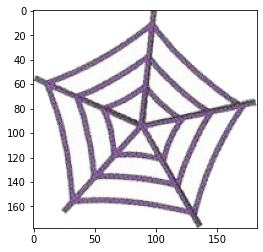

In [28]:
print(train_labels[0])
plt.imshow(train_images[0])
print(ref[1][np.where(ref[0] == train_labels[0])])

## Print test example

06
['bonhomme de neige\n']


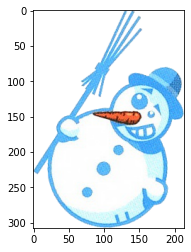

In [29]:
print(test_labels[0])
plt.imshow(test_images[0])
print(ref[1][np.where(ref[0] == test_labels[0])])

## Find all indices for a label

In [30]:
def find_all_labeled(label, labels):
    """
    Returns all indices of element like `label` in `labels`

    Parameters
    ----------
    label: str
        Searched label
    
    labels: [str]
        Dataset's labels
    """
    indices = []
    for i in range(labels.size):
        if labels[i] == label:
            indices.append(i)
    return indices

find_all_labeled(train_labels[0], train_labels)

[0, 64, 94]

## Summary

If you executed all of the above, you defined the following variables:

```python
ref # couple:
    ref[0] # labels' identifiers
    ref[1] # labels

train_labels # train dataset's images' identifiers for labels

train_images # train dataset's images

test_labels # test dataset's images' identifiers for labels

test_images # test dataset's images
```

## Image classifier

### 1. Augment datasets

In [31]:
from scipy import ndimage
from sklearn import svm, metrics

def augment_datasets(labels, images, nb=10):
    new_labels = []
    new_images = []
    original_size = len(labels)
    mat = [False for _ in range(original_size)]
    index = np.random.randint(original_size)
    for _ in range(nb):
        if not False in mat:
            mat = [False for _ in range(original_size)]
        while mat[index] == True:
            index = np.random.randint(original_size)
        mat[index] = True
        img = ndimage.rotate(images[index], np.random.rand() * 360, cval=255)
        new_labels.append(labels[index])
        new_images.append(img)
    return np.array(new_labels), np.array(new_images)

print(len(train_images))
train_labels_plus, train_images_plus = augment_datasets(train_labels, train_images, 1000)
print(len(train_images_plus))

171
1000


C:\Users\nuki\AppData\Local\Temp/ipykernel_15864/4019254287.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_labels), np.array(new_images)


### 2. Resize images

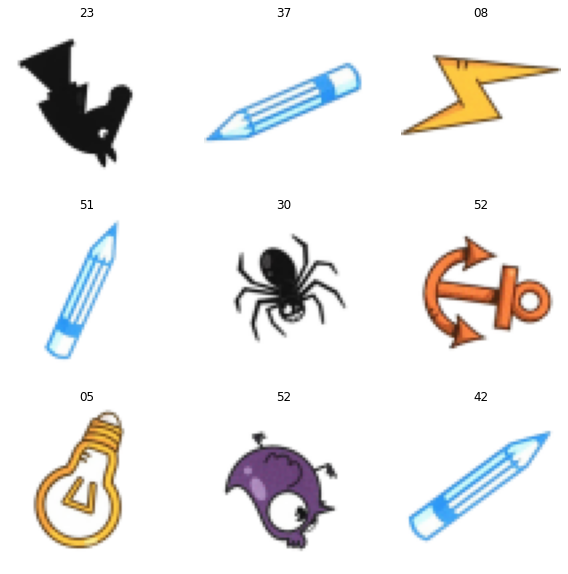

In [32]:
def image_resize(image, width, height, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    (h, w) = image.shape[:2]

    # calculate the ratio of the width and construct the
    # dimensions
    if w > h:
        r = width / float(w)
        dim = (width, int(h * r))
    else:
        r = height / float(h)
        dim = (int(w * r), height)

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    ret = np.full((height, width, 3), 255, np.uint8)
    

    y_offset = int((height - resized.shape[0]) / 2)
    x_offset = int((width - resized.shape[1]) / 2)
    ret[y_offset:y_offset+resized.shape[0], x_offset:x_offset+resized.shape[1]] = resized

    # return the resized image
    return ret

def resize_images(images):
    resized = []
    for image in images: 
        resized.append(image_resize(image, 60, 60))
    return resized

train_images_resized = np.array(resize_images(train_images_plus))
test_images_resized = np.array(resize_images(test_images))

plt.figure(figsize=(10, 10))
for j in range(9):
    #print(train_images_resized[j].shape[:2])
    ax = plt.subplot(3, 3, j + 1)
    plt.imshow(train_images_resized[j])
    plt.title(train_labels[j])
    plt.axis("off")

### 3. Display repartition

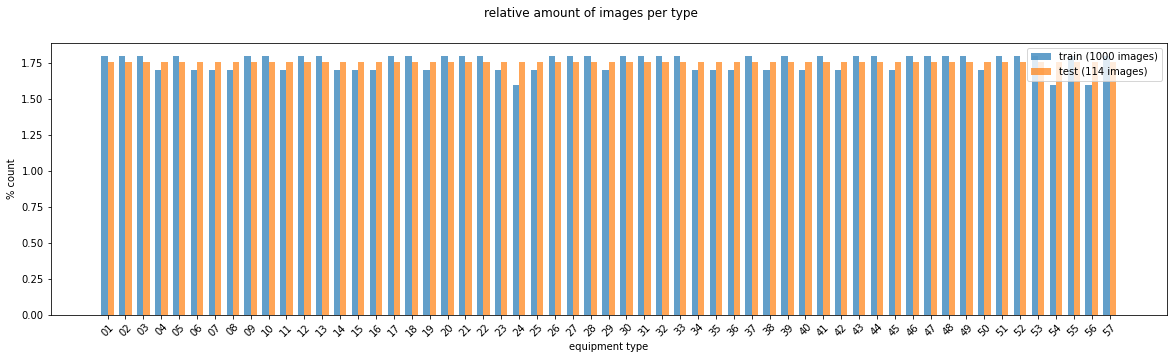

In [33]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.figure(figsize=(20, 5))
plt.suptitle('relative amount of images per type')
plot_bar(train_labels_plus, loc='left')
plot_bar(test_labels, loc='right')
plt.legend([
    'train ({0} images)'.format(len(train_labels_plus)), 
    'test ({0} images)'.format(len(test_labels))
]);

### 4. Train model

In [34]:
clf = svm.SVC(gamma=0.001)
nsamples, nx, ny, nz = train_images_resized.shape
x_train = train_images_resized.reshape((nsamples,nx*ny*nz))
x_train = x_train / 255
clf.fit(np.array(x_train), train_labels_plus)

c:\Users\nuki\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=5000)

### 5. Make prediction

0.5350877192982456


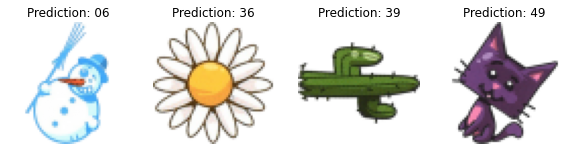

In [35]:
nsamples, nx, ny, nz = test_images_resized.shape
x_test = test_images_resized.reshape((nsamples,nx*ny*nz))
x_test = x_test / 255
predicted = clf.predict(x_test)

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, x_test, predicted):
    ax.set_axis_off()
    image = image.reshape(60, 60, 3)
    ax.imshow(image)
    ax.set_title(f"Prediction: {prediction}")

acc = (predicted == test_labels).sum()
print(acc / len(predicted))

## Color histogram
### 1. Color quantization

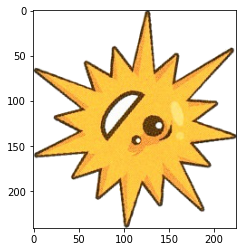

In [36]:
def get_each_image() :
    """
    Return one image of each type with corresponding labels
    """
    PATH_TO_RESOURCES = "ressources/train"
    images = []
    dirs = os.listdir(PATH_TO_RESOURCES)
    labels = []
    for name_dir in dirs : 
        if name_dir == "labels.txt" :
            continue
        actual_path = os.path.join(PATH_TO_RESOURCES, name_dir)
        img_name = os.listdir(actual_path)[0]
        img = cv2.imread(os.path.join(actual_path, img_name));
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
        images.append(img)
        labels.append(name_dir)
    return images, labels

each_images, each_labels = get_each_image()
plt.imshow(each_images[52])

(250, 14250, 3)

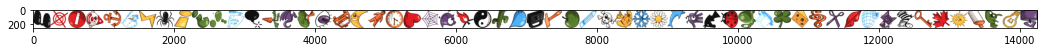

In [37]:
def create_poster(images) : 
    """
    Return a poster containing all images and a corresponding mask
    
    Parameters
    ----------        
    images: [image]
        Dataset's images
    """
    sizeImg = 250
    img0 = cv2.resize(images[0], (sizeImg, sizeImg))
    poster = img0
    first = True
    for img in images : 
        if first : 
            first = False
            continue
        img = cv2.resize(img, (sizeImg, sizeImg))
        poster = cv2.hconcat([poster, img])
    
    # Create a mask for the poster generated 
    poster_mask = np.zeros(poster.shape[0] * poster.shape[1])
    for i in range(poster.shape[0]) : 
        for j in range(poster.shape[1]) : 
            poster_mask[i * poster.shape[0] +  j] = np.all(poster[i, j] != 255)
    
    return poster, poster_mask

poster, poster_mask = create_poster(each_images)
plt.figure(figsize=(18,18))
plt.imshow(poster)
poster.shape

In [38]:
from sklearn.cluster import KMeans

def train_kmeans(poster, nb_colors) :
    """
    'Train' kmeans using poster's colors 
    Parameters
    ----------
    poster: image
        
    nb_colors: int
        Number of clusters for kmeans
    """
    plane_poster = poster.reshape(len(poster) * len(poster[0]), 3)
    kmeans = KMeans(n_clusters=nb_colors, random_state=0)
    kmeans.fit(plane_poster)
    kmeans.cluster_centers_
    label_map = kmeans.predict(plane_poster)
    return kmeans, label_map

kmeans, label_map = train_kmeans(poster, 10)

<BarContainer object of 10 artists>

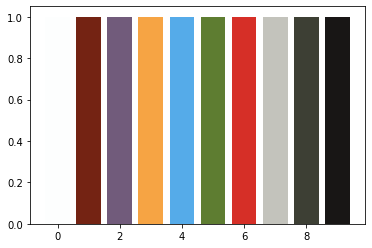

In [39]:
color_lut = np.uint8(kmeans.cluster_centers_)
plt.bar(np.arange(len(color_lut)), 
         np.ones(len(color_lut)), 
         color=color_lut/255)

### 2. Color histograms

In [40]:
def reduce_color(img, kmeans) : 
    """
    Reduce the colors in an image
    
    Parameters
    ----------
    img: image
        Reference image
    kmeans: Kmeans
        kmeans used to determine new colors
    """
    newImg = np.zeros_like((0, 0, 0), shape=img.shape)
    prediction = kmeans.predict(img.reshape(len(img) * len(img[0]), 3))
    histo = np.zeros(len(kmeans.cluster_centers_))
    for i in range(len(img)) : 
        for j in range(len(img[0])) :
            if img[i, j][0] == 255 and img[i, j][1] == 255 and img[i, j][2] == 255: 
                newImg[i, j] = [255, 255,255]
            else :
                newImg[i, j] = kmeans.cluster_centers_[prediction[i * len(img[0]) + j]]
                histo[prediction[i * len(img[0]) + j]] += 1
    return newImg, histo

def normalize_histogram(histo) : 
    """
    Normalize histogram
    
    Parameter
    ----------
    histo: [int]
        image histogram
    """
    nbPixels = np.sum(histo)
    for i in range(len(histo)) : 
        if histo[i] != 0 :
            histo[i] = histo[i] / nbPixels
    return histo

In [41]:
# Reduce color of all images
images_quant = []
color_histograms = []
for i in range(len(each_images)) : 
    newImg, histo = reduce_color(each_images[i], kmeans)
    images_quant.append(newImg)
    # Normalise histogram
    histo = normalize_histogram(histo)
    color_histograms.append(histo) 

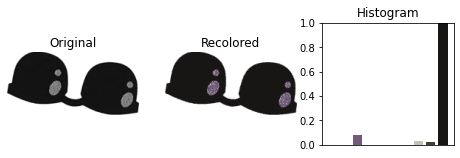

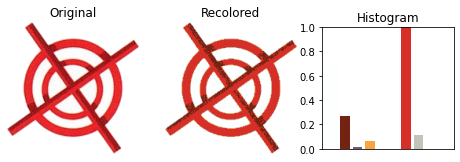

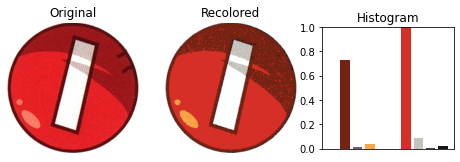

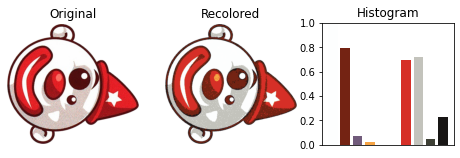

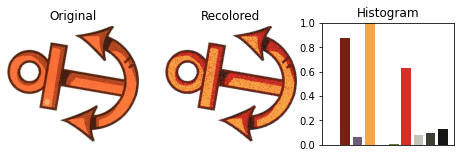

In [42]:
# Show some color histograms with colors!
colors_for_bars = color_lut/255  # matplotlib colors are RGB values scaled to [0,1]
for ii in range(5):
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(each_images[ii])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(images_quant[ii])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[ii])), 
            color_histograms[ii]/color_histograms[ii].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

### Test without classifier just using histogram comparison

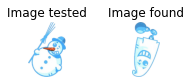

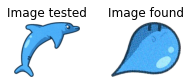

Accuracy:  0.98


In [43]:
import scipy as sc

good_result = 0
for i in range(len(test_images)) : 
    test_img = test_images[i]
    test_img_recolored, test_histo = reduce_color(test_img, kmeans)
    test_histo = normalize_histogram(test_histo)
    minimal_distance = sc.spatial.distance.pdist(np.vstack((test_histo, color_histograms[0])))
    best_index = 0
    
    for j in range(1, len(color_histograms)) :
        dist = sc.spatial.distance.pdist(np.vstack((test_histo, color_histograms[j])))
        if dist < minimal_distance : 
            minimal_distance = dist 
            best_index = j
    # Check que le result est bon
    if test_labels[i] == each_labels[best_index] :
        good_result += 1
    else :
        plt.figure(figsize=(5,1))
        plt.subplot(1,3, 1)
        plt.imshow(test_img)
        plt.axis('off'); plt.title("Image tested")
        plt.subplot(1,3,2)
        plt.imshow(each_images[best_index])
        plt.axis('off'); plt.title("Image found")
        plt.show()
    
accuracy = good_result / len(test_images)
print("Accuracy: ", round(accuracy, 2))

### Test linear classifier

In [44]:
# Get images histograms
def get_images_histograms(images) : 
    histograms = []
    for i in range(len(images)) : 
        actual_img = images[i]
        actual_img_recolored, img_histo = reduce_color(actual_img, kmeans)
        actual_histo = normalize_histogram(img_histo)
        histograms.append(actual_histo)
    return histograms

train_histograms = get_images_histograms(train_images)
test_histograms = get_images_histograms(test_images)

In [45]:
import sklearn as sk
import sklearn.dummy
import sklearn.ensemble

def classifier_test(clf, clf_name) : 
    clf.fit(train_histograms, train_labels)
    label_pred = clf.predict(test_histograms)

    good = 0
    for i in range(len(label_pred)) : 
        if label_pred[i] == test_labels[i] :
            good += 1
    accuracy = good / len(label_pred)
    print(clf_name + '. Accuracy:', round(accuracy, 3))

print("Test de différents classifiers :\n")
clf = sk.svm.LinearSVC()
classifier_test(clf, "Linear SVC")
clf = sk.neighbors.KNeighborsClassifier(n_neighbors=1)
classifier_test(clf, "KNeighbors (1 neighbor)")
clf = sk.neighbors.KNeighborsClassifier(n_neighbors=5)
classifier_test(clf, "KNeighbors (3 neighbors)")
classifier_test(sk.dummy.DummyClassifier(), "Dummy")
classifier_test(sk.ensemble.RandomForestClassifier(n_estimators=10), "RandomForest (10 estimators)")
classifier_test(sk.ensemble.RandomForestClassifier(n_estimators=100), "RandomForest (100 estimators)")
classifier_test(sk.ensemble.RandomForestClassifier(n_estimators=57), "RandomForest (57 estimators)")


Test de différents classifiers :

Linear SVC. Accuracy: 0.518
KNeighbors (1 neighbor). Accuracy: 0.974
KNeighbors (3 neighbors). Accuracy: 0.947
Dummy. Accuracy: 0.018
RandomForest (10 estimators). Accuracy: 0.939
RandomForest (100 estimators). Accuracy: 0.956
RandomForest (57 estimators). Accuracy: 0.965


In [46]:
clf = sk.neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(train_histograms, train_labels)
probas = clf.predict_proba(test_histograms)

print("Errors found and corresponding probabilities.\n")
for i in range(len(probas)) :
    label_pred = clf.classes_[np.where(probas[i] == np.amax(probas[i]))]
    if label_pred[0] != test_labels[i] :
        labels_proba = ""
        for j in range(len(probas[0])) : 
            if probas[i][j] > 0 : 
                label = clf.classes_[j]
                labels_proba += label + "/" + str(probas[i][j]) + "; "
        print("Label wanted:", test_labels[i], ". Labels get/proba: ", labels_proba)

Errors found and corresponding probabilities.

Label wanted: 06 . Labels get/proba:  06/0.4; 12/0.6; 
Label wanted: 47 . Labels get/proba:  47/0.4; 52/0.6; 
Label wanted: 08 . Labels get/proba:  01/0.4; 08/0.4; 13/0.2; 
Label wanted: 37 . Labels get/proba:  28/0.6; 37/0.4; 
Label wanted: 49 . Labels get/proba:  38/0.6; 49/0.4; 
Label wanted: 46 . Labels get/proba:  38/0.6; 46/0.4; 


## Descripteur de forme
### Topological and geometrical features
#### Center image to object

In [47]:
####### Center image to object #######

def top_image(img):
    for i in range(len(img)):
        for j in range(len(img[0])):
            if (img[i][j] == 255):
                return i
            
def bottom_image(img):
    for i in reversed(range(len(img) - 1)):
        for j in range(len(img[0])):
            if (img[i][j] == 255):
                return i
            
def left_image(img):
    for i in range(len(img[0])):
        for j in range(len(img)):
            if (img[j][i] == 255):
                return i
            
def right_image(img):
    for i in reversed(range(len(img[0]) - 1)):
        for j in range(len(img)):
            if (img[j][i] == 255):
                return i

def center_image(curr_img):
    top = top_image(curr_img)
    bottom = bottom_image(curr_img)
    left = left_image(curr_img)
    right = right_image(curr_img)
    centered_img = curr_img[top:bottom, left:right]
    return centered_img

#### Resize image without distortion

In [48]:
###### Resize image without distortion ######

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    
    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

#### Count number of holes

In [49]:
###### Count number of holes ######

def count_holes(image, display):
    img = image.copy()
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Threshold the image
    ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    
    nb_holes = 0
    max_num = np.amax(hierarchy) +1
    for c, h in zip(contours, hierarchy[0]):
        # If there is at least one interior contour, find out how many there are
        if h[2] != -1:
            # Make sure it's not the 'zero' contour
            if h[0] == -1:
                num_interior_contours = max_num - h[2]
            else:
                num_interior_contours = h[0]-h[2]
        else:
            num_interior_contours = 0
        nb_holes += num_interior_contours
    if (display):
        print("Number of holes:", nb_holes)
    return nb_holes

#### Compute number of components and area size

In [50]:
######### Compute number of components and area size #########

import math

def connected_components(img, display):
    # load the input image from disk, convert it to grayscale, and
    # threshold it
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    #print(centroids[1:])
    # initialize an output mask to store all characters parsed from
    # image
    mask = np.zeros(gray.shape, dtype="uint8")
    
    # loop over the number of unique connected component labels, skipping
    # over the first label (as label zero is the background)
    nb_components = 0
    sum_area = 0
    for i in range(1, numLabels):
        # extract the connected component statistics for the current
        # label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        
        keepArea = area > 50
        # ensure the connected component we are examining passes all
        # three tests
        if (keepArea):
            nb_components += 1
            sum_area += area
            # construct a mask for the current connected component and
            # then take the bitwise OR with the mask
            #print("[INFO] keeping connected component '{}'".format(i))
            componentMask = (labels == i).astype("uint8") * 255
            mask = cv2.bitwise_or(mask, componentMask)
    if (display):
        print("Number of components:", nb_components)
        print("Area size:", sum_area)
    return (nb_components, sum_area)
    

#### Compute skeleton

In [51]:
######### Compute skeleton #########

def compute_skeleton(img, display):
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Threshold the image
    ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Step 1: Create an empty skeleton
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    # Get a Cross Shaped Kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # Repeat steps 2-4
    while True:
        #Step 2: Open the image
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        #Step 3: Substract open from the original image
        temp = cv2.subtract(img, open)
        #Step 4: Erode the original image and refine the skeleton
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
        if cv2.countNonZero(img)==0:
            break
    return skel

#### Perform rotation along longest contour

In [52]:
# override imutils rotate_bound function to add bordervalue parameter in warpAffine
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderValue=(255,255,255))

def getOrientation(pts, img):
    ## [pca]
    # Construct a buffer used by the pca analysis
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]

    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)

    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    ## [pca]

    angle = math.atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians

    return angle

def rotate_with_contours(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Convert image to binary
    _, bw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    tmp = cv2.bitwise_not(bw)
    # Find all the contours in the thresholded image
    contours, _ = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    largest_area = 0
    rotation = 0
    for i, c in enumerate(contours):
        # Calculate the area of each contour
        area = cv2.contourArea(c)
        # Ignore contours that are too small or too large
        if area < 1500 or 100000 < area:
            continue

        # Find the orientation of each shape
        angle = getOrientation(c, img)
        if (largest_area < area):
            largest_area = area
            rotation = angle * 180 / math.pi
    return rotate_bound(img, -rotation)

#### Alexandre's count faces of biggest convex contour

In [53]:
###### Alexandre's count faces of biggest convex contour ######

def is_white(pixel):
    sum_rgb = int(pixel[0]) + int(pixel[1]) + int(pixel[2])
    return sum_rgb > 700

def binarize(img):
    ret = img.copy()
    for i in range(len(img)):
        for j in range(len(img[0])):
            if is_white(img[i][j]):
                ret[i][j] = [0, 0, 0]
            else:
                ret[i][j] = [255, 255, 255]
    return ret

def count_faces(img):
    binary = binarize(img)
    imgray = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img = np.zeros((len(binary),len(binary[0]),3), np.uint8)
    cv2.drawContours(img, contours, 0, (0,255,0), 3)
    convex = np.array([])
    hull = []
    sides = []
    for i in range(len(contours)):
        cht = cv2.convexHull(contours[i], returnPoints=True)
        hull.append(cht)
        sides.append(cv2.approxPolyDP(cht, 15, True))

    drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
    for i in range(len(contours)):
        color_contours = (0, 255, 0) # green - color for contours
        color = (255, 0, 0) # blue - color for convex hull
        cv2.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
        cv2.drawContours(drawing, hull, i, color, 1, 8)

    return len(sides[0]), drawing

def face_rate(img):
    rate = count_faces(img)[0] / 10
    if rate > 1:
        return 1
    return rate

#### Extract all features from image

In [54]:
####### Extract all features from image ######

def features_from_image(image, display):
    img = image.copy()
    features = []

    # compute number of components and area size
    (number_of_components, area_size) = connected_components(img, display) 
    features.append(number_of_components / 10)
    features.append(area_size / 50000)
    
    # compute number of holes
    number_of_holes = count_holes(img, display)
    features.append(number_of_holes / 150)
    
    # Euler number
    euler_number = number_of_components - number_of_holes
    if (display):
        print("Euler number:", euler_number)
    features.append(euler_number / 6)
    
    # Alexandre's count faces of biggest convex contour
    rate = face_rate(img)
    features.append(rate)
    
    # perform rotation based on contours
    rotated = rotate_with_contours(img)
    
    # skeletonize the image
    skeleton = compute_skeleton(rotated, display)
    
    # center image to object
    centered_img = center_image(skeleton)
    
    # resize image to fixed size (without distortion)
    resized_img = image_resize(centered_img,180,180)
    if (display):
        plt.imshow(img)
        plt.show()
        plt.imshow(resized_img, cmap='gray', vmin=0, vmax=255)
        plt.show()
    
    # perform gaussianblur
    blurred_img = cv2.GaussianBlur(resized_img,(7,7),0)
    if (display):
        plt.imshow(blurred_img, cmap='gray', vmin=0, vmax=255)
        plt.show()
    
    # add some padding to get a squared image
    padded = cv2.copyMakeBorder(blurred_img, 0, 224 - blurred_img.shape[0], 0, 224 - blurred_img.shape[1], cv2.BORDER_CONSTANT, value=[0,0,0])
    
    return np.concatenate((np.array(features), padded.flat))

#### Plot features

Number of components: 1
Area size: 6734
Number of holes: 15
Euler number: -14


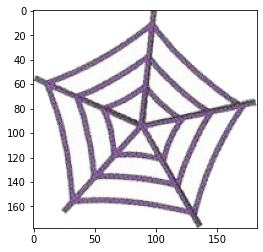

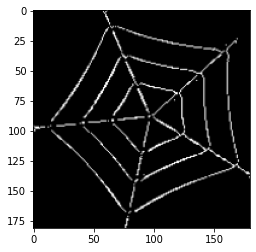

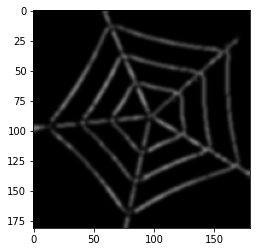

Combined features: [0.1     0.13468 0.1     ... 0.      0.      0.     ] 

Number of components: 1
Area size: 26087
Number of holes: 0
Euler number: 1


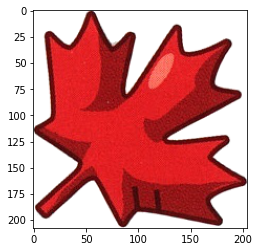

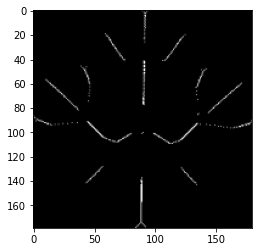

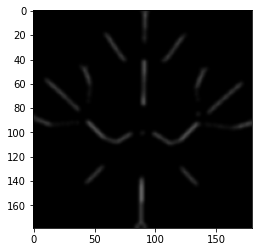

Combined features: [0.1     0.52174 0.      ... 0.      0.      0.     ]


In [55]:
print("Combined features:", features_from_image(train_images[0], True), '\n')
print("Combined features:", features_from_image(train_images[5], True))

#### Combine features for training and testing (Early fusion)

In [56]:
display = False

train_topological_features = [features_from_image(train_img, display) for train_img in train_images]
test_topological_features = [features_from_image(test_img, display) for test_img in test_images]

## Results with some classifiers

In [ ]:
from sklearn.dummy import DummyClassifier

early_classifier = DummyClassifier().fit(train_topological_features, train_labels)
early_classifier.score(test_topological_features, test_labels)

0.017543859649122806

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

early_classifier = KNeighborsClassifier(n_neighbors=3).fit(train_topological_features, train_labels)
early_classifier.score(test_topological_features, test_labels)

0.7105263157894737

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

early_classifier = KNeighborsClassifier(n_neighbors=1).fit(train_topological_features, train_labels)
early_classifier.score(test_topological_features, test_labels)

0.7982456140350878

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

early_classifier = make_pipeline(StandardScaler(), SVC()).fit(train_topological_features, train_labels)
early_classifier.score(test_topological_features, test_labels)

0.7807017543859649

In [ ]:
from sklearn.ensemble import RandomForestClassifier
early_classifier = RandomForestClassifier().fit(train_topological_features, train_labels)
early_classifier.score(test_topological_features, test_labels)

0.8596491228070176

## Shape matching
### 1. Hu moments
#### Image treatment

In [ ]:
def grayscale(img):
    return np.dot(img[..., :3], [.299, .587, .114])

In [ ]:
def inverted(img):
    return np.full(img.shape, 255) - img

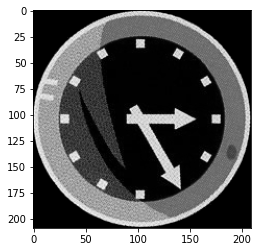

In [ ]:
plt.imshow(inverted(grayscale(test_images[11])), cmap = 'gray')

#### Moments

In [ ]:
def raw_moment(i, j, img):
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += x ** i * y ** j * img[y][x]
    return moment

In [ ]:
def central_moment(i, j, img):
    avg_moment = raw_moment(0, 0, img)
    x_centroid = raw_moment(1, 0, img) / avg_moment
    y_centroid = raw_moment(0, 1, img) / avg_moment
    
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += (x - x_centroid) ** i * (y - y_centroid) ** j * img[y][x]
    return moment

In [ ]:
def central_moment_opt(centroid, i, j, img):
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += (x - centroid[0]) ** i * (y - centroid[1]) ** j * img[y][x]
    return moment

In [ ]:
def scale_invariant_moment(i, j, img):
    assert i + j >= 2
    return central_moment(i, j, img) / central_moment(0, 0, img) ** (1 + (i + j) / 2)

In [ ]:
def scale_invariant_moment_opt(centroid, c0, i, j, img):
    assert i + j >= 2
    return central_moment_opt(centroid, i, j, img) / c0 ** (1 + (i + j) / 2)

#### Hu Moments

In [ ]:
def hu_moments(img):
    img_gray = inverted(grayscale(img))
    
    nu20 = scale_invariant_moment(2, 0, img_gray)
    nu11 = scale_invariant_moment(1, 1, img_gray)
    nu02 = scale_invariant_moment(0, 2, img_gray)
    nu30 = scale_invariant_moment(3, 0, img_gray)
    nu21 = scale_invariant_moment(2, 1, img_gray)
    nu12 = scale_invariant_moment(1, 2, img_gray)
    nu03 = scale_invariant_moment(0, 3, img_gray)
    
    I0 = (nu20 + nu02)
    
    I1 = ((nu20 - nu02) ** 2 +
          4 * nu11 ** 2)
    
    I2 = ((nu30 - 3 * nu12) ** 2 +
          (3 * nu21 - nu03) ** 2)
    
    I3 = ((nu30 + nu12) ** 2 +
          (nu21 + nu03) ** 2)
    
    I4 = ((nu30 - 3 * nu12) * (nu30 + nu12) *
          ((nu30 + nu12) ** 2 - 3 * (nu21 + nu03) ** 2) +
          (3 * nu21 - nu03) * (nu21 + nu03) *
          (3 * (nu30 + nu12) ** 2 - (nu21 + nu03) ** 2))
    
    I5 = ((nu20 - nu02) * ((nu30 + nu12) ** 2 - (nu21 + nu03) ** 2) +
          4 * nu11 * (nu30 + nu12) * (nu21 + nu03))
    
    I6 = ((3 * nu21 - nu03) * (nu30 + nu12) *
          ((nu30 + nu12) ** 2 - 3 * (nu21 + nu03) ** 2) -
          (nu30 - 3 * nu12) * (nu21 + nu03) *
          (3 * (nu30 + nu12) ** 2 - (nu21 + nu03) ** 2))
    
    return [I0, I1, I2, I3, I4, I5, I6]

In [ ]:
def hu_moments_opt(img):
    img_gray = inverted(grayscale(img))
    
    avg = raw_moment(0, 0, img_gray)
    centroid = (raw_moment(1, 0, img_gray) / avg, raw_moment(0, 1, img_gray) / avg)
    
    c0 = central_moment_opt(centroid, 0, 0, img_gray)
    
    nu20 = scale_invariant_moment_opt(centroid, c0, 2, 0, img_gray)
    nu11 = scale_invariant_moment_opt(centroid, c0, 1, 1, img_gray)
    nu02 = scale_invariant_moment_opt(centroid, c0, 0, 2, img_gray)
    nu30 = scale_invariant_moment_opt(centroid, c0, 3, 0, img_gray)
    nu21 = scale_invariant_moment_opt(centroid, c0, 2, 1, img_gray)
    nu12 = scale_invariant_moment_opt(centroid, c0, 1, 2, img_gray)
    nu03 = scale_invariant_moment_opt(centroid, c0, 0, 3, img_gray)
    
    hu = np.zeros(7)
    
    t0 = nu30 + nu12;
    t1 = nu21 + nu03;

    q0 = t0 * t0
    q1 = t1 * t1;

    n4 = 4 * nu11;
    s = nu20 + nu02;
    d = nu20 - nu02;

    hu[0] = s;
    hu[1] = d * d + n4 * nu11;
    hu[3] = q0 + q1;
    hu[5] = d * (q0 - q1) + n4 * t0 * t1;

    t0 *= q0 - 3 * q1;
    t1 *= 3 * q0 - q1;

    q0 = nu30 - 3 * nu12;
    q1 = 3 * nu21 - nu03;

    hu[2] = q0 * q0 + q1 * q1;
    hu[4] = q0 * t0 + q1 * t1;
    hu[6] = q1 * t0 - q0 * t1;
    
    return hu

In [ ]:
def compute_moments_diff(hu_1, hu_2):
    diff = 0
    for i in range(7):
        diff += (hu_2[i] - hu_1[i]) ** 2
        
    return math.sqrt(diff)

In [ ]:
def moments_from(images):
    hu_mo = np.zeros((len(images), 7))
    for ii in range(len(images)):
        hu_mo[ii] = hu_moments_opt(images[ii])
    return hu_mo * 1e6

#### Classifiers

In [ ]:
train_moments = moments_from(train_images)

In [ ]:
test_moments = moments_from(test_images)

In [ ]:
from sklearn.dummy import DummyClassifier

km = DummyClassifier().fit(train_moments, train_labels) # 56%
km.score(test_moments, test_labels)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

km = make_pipeline(StandardScaler(), LinearSVC(max_iter=1500)).fit(train_moments, train_labels) # 29%
km.score(test_moments, test_labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

km = KNeighborsClassifier(n_neighbors=6).fit(train_moments, train_labels) # 46%
km.score(test_moments, test_labels)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

km = make_pipeline(StandardScaler(), SVC()).fit(train_moments, train_labels) # 87%
km.score(test_moments, test_labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

km = RandomForestClassifier().fit(train_moments, train_labels) # 100%
km.score(test_moments, test_labels)

In [ ]:
print(km.predict_proba(test_moments)[2])
print(km.classes_)
print(km.predict(test_moments)[2])

## Early Fusion

### Color histogram & Hu moments

In [ ]:
train_early = [np.concatenate((train_histograms[i], train_moments[i])) for i in range(len(train_moments))]
test_early = [np.concatenate((test_histograms[i], test_moments[i])) for i in range(len(test_moments))]

In [ ]:
from sklearn.dummy import DummyClassifier

early_classifier = DummyClassifier().fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

early_classifier = KNeighborsClassifier(n_neighbors=4).fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

early_classifier = make_pipeline(StandardScaler(), SVC()).fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

early_classifier = make_pipeline(StandardScaler(), LinearSVC(max_iter=1500)).fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

early_classifier = RandomForestClassifier().fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

## Late Fusion

### Color histogram & Hu moments

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

col_classifier = KNeighborsClassifier(n_neighbors=5).fit(train_histograms, train_labels)
hu_classifier = RandomForestClassifier().fit(train_moments, train_labels)

In [ ]:
col_results = col_classifier.predict_proba(test_histograms), col_classifier.classes_
hu_results = hu_classifier.predict_proba(test_moments), hu_classifier.classes_

In [ ]:
results = col_results[0] + hu_results[0], col_results[1]

final = np.empty(len(results[0]), dtype='object')
for ii in range(results[0].shape[0]):
    imax = results[0][ii]
    final[ii] = col_results[1][imax.argmax()]

In [ ]:
#Classifier save for test program
import joblib 

joblib.dump(col_classifier, "col.clf")
joblib.dump(hu_classifier, "hu.clf")
joblib.dump(kmeans, "km_col.clf")

clf_hu = joblib.load("hu.clf")
clf_hu.score(test_moments, test_labels)
clf_hu.score([test_moments[0]], [test_labels[0]])